In [18]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda if cuda_available else "CUDA not available"
cudnn_version = torch.backends.cudnn.version() if cuda_available else "cuDNN not available"

print(f"CUDA Available: {cuda_available}")
print(f"CUDA Version: {cuda_version}")
print(f"cuDNN Version: {cudnn_version}")

# Check the GPU device name
if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

CUDA Available: False
CUDA Version: CUDA not available
cuDNN Version: cuDNN not available


# S&P 500 Prediction Analysis using Toto

This notebook walks through the process of fetching S&P 500 data, preparing it for the Toto model, and generating predictions. We'll examine the data and results at each important step.

In [19]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prepare_stock_data import fetch_sp500_data, prepare_for_toto
from toto.model.toto import Toto
from toto.inference.forecaster import TotoForecaster

# Set plotting style
# plt.style.use('seaborn')
# sns.set_palette("husl")

## 1. Data Collection

First, let's fetch the S&P 500 data and examine its basic properties.

In [20]:
# Fetch data
data = fetch_sp500_data()

print("Data shape:", data.shape)
print("\nDate range:")
print(f"Start: {data.index[0]}")
print(f"End: {data.index[-1]}")

# Display first few rows
display(data.head())

[*********************100%***********************]  1 of 1 completed

Data shape: (3335, 9)

Date range:
Start: 2023-06-29 18:30:00+00:00
End: 2025-05-28 19:30:00+00:00


,Open,High,Low,Close,Volume,Volume_MA,Price_MA_short,Price_MA_long,Volatility
Datetime,,,,,,,,,
2023-06-29 18:30:00+00:00,4387.850098,4393.569824,4384.459961,4392.479980,0,NaN,NaN,NaN,NaN
2023-06-29 19:30:00+00:00,4392.479980,4397.149902,4387.370117,4396.859863,337021000,NaN,NaN,NaN,NaN
2023-06-30 13:30:00+00:00,4422.439941,4449.129883,4422.439941,4445.970215,456406930,NaN,NaN,NaN,NaN
2023-06-30 14:30:00+00:00,4445.979980,4448.700195,4436.250000,4442.640137,284352271,NaN,NaN,NaN,NaN
2023-06-30 15:30:00+00:00,4442.560059,4446.100098,4435.930176,4446.100098,211529403,NaN,NaN,NaN,NaN


## 2. Data Visualization

Let's visualize the key features of our dataset.

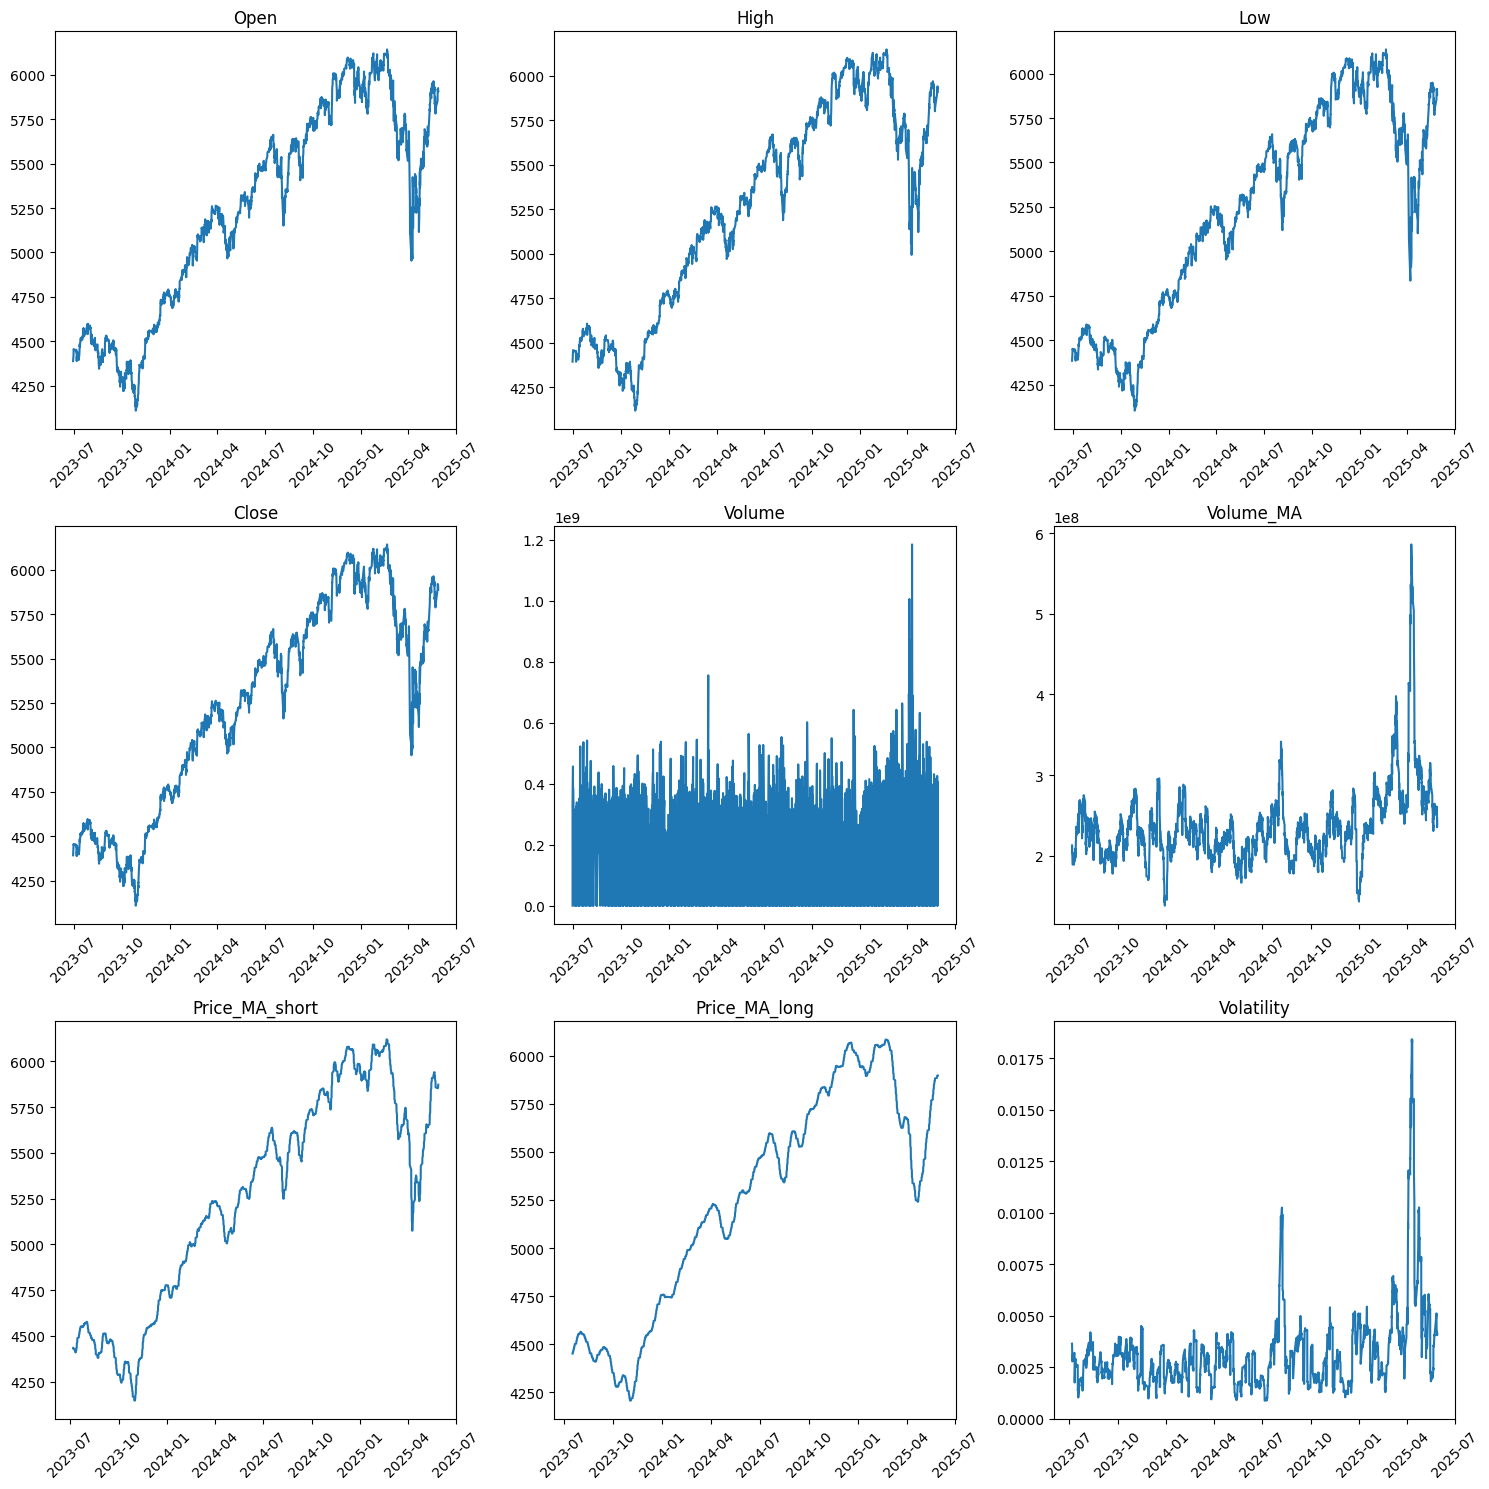

In [21]:
def plot_features(data, columns, rows=3):
    cols = (len(columns) + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        axes[i].plot(data.index, data[col])
        axes[i].set_title(col)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Plot all features
plot_features(data, data.columns)

## 3. Data Normalization

Let's examine how our robust normalization affects the data distribution.

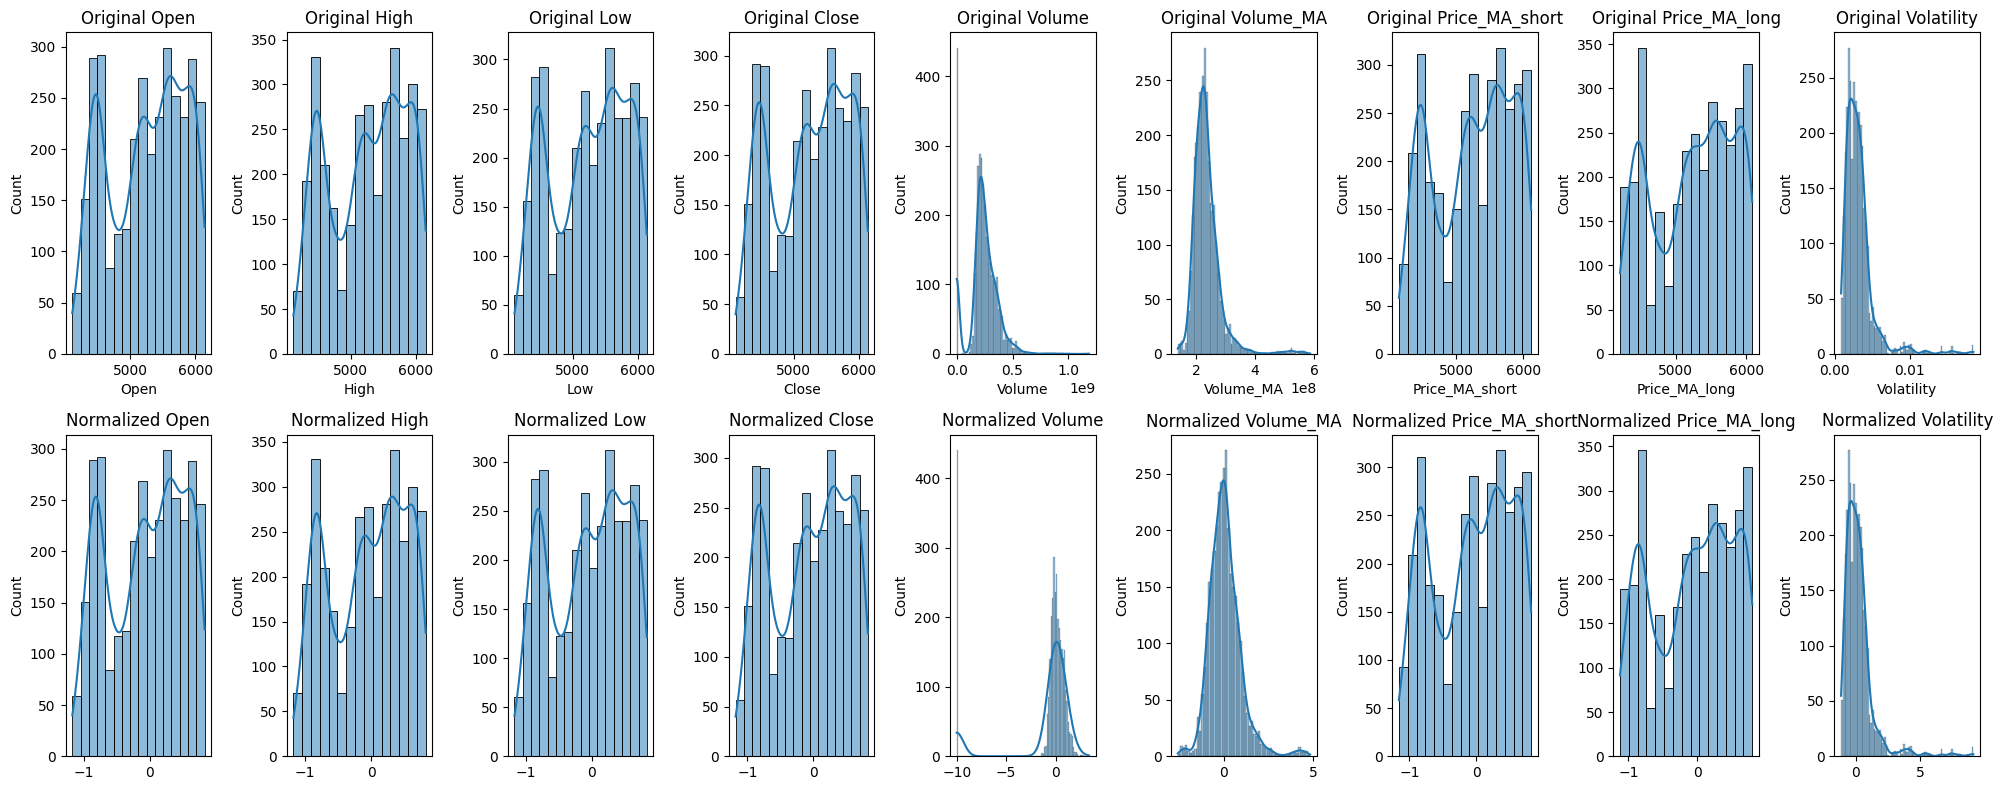

In [22]:
def plot_distributions(data, normalized_data):
    fig, axes = plt.subplots(2, len(data.columns), figsize=(20, 8))
    
    for i, col in enumerate(data.columns):
        # Original distribution
        sns.histplot(data[col], ax=axes[0, i], kde=True)
        axes[0, i].set_title(f'Original {col}')
        
        # Normalized distribution
        sns.histplot(normalized_data[col], ax=axes[1, i], kde=True)
        axes[1, i].set_title(f'Normalized {col}')
    
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Get normalized data (before tensor conversion)
normalized_data = {}
for column in data.columns:
    series = data[column].values
    
    if column in ['Volume', 'Volume_MA']:
        series = np.log1p(series)
    elif column == 'Volatility':
        series = np.maximum(series, 0)
    
    q1 = np.percentile(series[~np.isnan(series)], 25)
    q3 = np.percentile(series[~np.isnan(series)], 75)
    iqr = q3 - q1
    
    if iqr > 0:
        median = np.median(series[~np.isnan(series)])
        normalized_data[column] = (series - median) / (iqr + 1e-8)
    else:
        mean = np.mean(series[~np.isnan(series)])
        std = np.std(series[~np.isnan(series)])
        normalized_data[column] = (series - mean) / (std + 1e-8)
    
    normalized_data[column] = np.clip(normalized_data[column], -10, 10)

# Plot distributions
plot_distributions(data, normalized_data)

In [23]:
from sklearn.preprocessing import StandardScaler

# Normalize the data using StandardScaler
scaler = StandardScaler()
normalized_array = scaler.fit_transform(data)
normalized_df = pd.DataFrame(normalized_array, columns=data.columns, index=data.index)

display(normalized_df)

,Open,High,Low,Close,Volume,Volume_MA,Price_MA_short,Price_MA_long,Volatility
Datetime,,,,,,,,,
2023-06-29 18:30:00+00:00,-1.489353,-1.493024,-1.481856,-1.481672,-1.854629,NaN,NaN,NaN,NaN
2023-06-29 19:30:00+00:00,-1.481270,-1.486786,-1.476763,-1.474025,0.796670,NaN,NaN,NaN,NaN
2023-06-30 13:30:00+00:00,-1.428966,-1.396215,-1.415397,-1.388282,1.735863,NaN,NaN,NaN,NaN
2023-06-30 14:30:00+00:00,-1.387870,-1.396964,-1.391231,-1.394096,0.382332,NaN,NaN,NaN,NaN
2023-06-30 15:30:00+00:00,-1.393840,-1.401495,-1.391791,-1.388055,-0.190555,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-05-28 15:30:00+00:00,1.160716,1.151584,1.173230,1.168607,-0.029139,-0.011295,1.090092,1.159198,0.422269
2025-05-28 16:30:00+00:00,1.168782,1.162178,1.184796,1.175207,-0.313707,0.157318,1.095455,1.159698,0.419368
2025-05-28 17:30:00+00:00,1.175468,1.159442,1.181944,1.171732,-0.190496,0.022808,1.100800,1.160173,0.419536


In [24]:
train = normalized_df.iloc[:-20]
test = normalized_df.iloc[-20:]

In [25]:
normalized_numpy = train.to_numpy()

### Using TOTO here

In [26]:
# import torch
# from data.util.dataset import MaskedTimeseries
# from inference.forecaster import TotoForecaster
# from model.toto import Toto

# # DEVICE = 'cuda'
# DEVICE = 'cpu'

# # Load pre-trained Toto model
# toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0').to(DEVICE)

# # Optional: compile model for enhanced speed
# toto.compile()

# forecaster = TotoForecaster(toto.model)

# # Example input series (7 variables, 4096 timesteps)
# input_series = torch.tensor(normalized_numpy).to(DEVICE)
# timestamp_seconds = torch.zeros(7, 4096).to(DEVICE)
# time_interval_seconds = torch.full((7,), 60*15).to(DEVICE)

# inputs = MaskedTimeseries(
#     series=input_series,
#     padding_mask=torch.full_like(input_series, True, dtype=torch.bool),
#     id_mask=torch.zeros_like(input_series),
#     timestamp_seconds=timestamp_seconds,
#     time_interval_seconds=time_interval_seconds,
# )

# # Generate forecasts for next 336 timesteps
# forecast = forecaster.forecast(
#     inputs,
#     prediction_length=20,
#     num_samples=256,
#     samples_per_batch=256,
# )

# # Access results
# median_prediction = forecast.median
# prediction_samples = forecast.samples
# lower_quantile = forecast.quantile(0.1)
# upper_quantile = forecast.quantile(0.9)


## 4. Model Preparation and Prediction

Now let's prepare the data for Toto and generate predictions.

In [ ]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Prepare data for Toto
toto_input, normalization_params = prepare_for_toto(data, device=device)
# toto_input = input_series = torch.tensor(normalized_numpy).to(device)

# Load model
toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0').to(device)
toto.compile()

# Create forecaster
forecaster = TotoForecaster(toto.model)

# Generate forecasts
prediction_hours = 168  # 1 week
forecast = forecaster.forecast(
    toto_input,
    prediction_length=prediction_hours,
    num_samples=256,
    samples_per_batch=256,
)

Using device: cpu


## 5. Visualization of Predictions

Let's visualize the predictions with confidence intervals for each feature.

In [0]:
def plot_predictions(data, forecast, feature_idx, feature_name):
    # Get the last timestamp from historical data
    last_timestamp = data.index[-1]
    
    # Create future timestamps
    future_timestamps = pd.date_range(
        start=last_timestamp,
        periods=forecast.median.shape[-1] + 1,
        freq='H'
    )[1:]
    
    plt.figure(figsize=(15, 7))
    
    # Plot historical data
    plt.plot(data.index[-168:], data[feature_name].values[-168:], 
             label='Historical', color='blue')
    
    # Plot predictions
    median_pred = forecast.median[0, feature_idx].cpu().numpy()
    lower_pred = forecast.quantile(0.1)[0, feature_idx].cpu().numpy()
    upper_pred = forecast.quantile(0.9)[0, feature_idx].cpu().numpy()
    
    plt.plot(future_timestamps, median_pred, 
             label='Prediction', color='red', linestyle='--')
    plt.fill_between(future_timestamps, lower_pred, upper_pred, 
                     color='red', alpha=0.2, label='90% Confidence Interval')
    
    plt.title(f'S&P 500 {feature_name} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Plot predictions for each feature
for idx, feature in enumerate(data.columns):
    plot_predictions(data, forecast, idx, feature)

## 6. Analysis of Prediction Quality

Let's analyze the quality of our predictions by looking at the distribution of samples and uncertainty.

In [0]:
def analyze_prediction_uncertainty(forecast, feature_idx, feature_name):
    # Get all samples for the feature
    samples = forecast.samples[:, 0, feature_idx].cpu().numpy()
    
    # Calculate uncertainty metrics
    std_dev = np.std(samples, axis=0)
    mean = np.mean(samples, axis=0)
    
    plt.figure(figsize=(15, 5))
    
    # Plot standard deviation over time
    plt.plot(std_dev, label='Standard Deviation')
    plt.title(f'Prediction Uncertainty Over Time - {feature_name}')
    plt.xlabel('Hours into Future')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.grid(True)
    display(plt.gcf())
    plt.close()

# Analyze uncertainty for Close price
analyze_prediction_uncertainty(forecast, 3, 'Close')

## 7. Save Results to Delta Table (Databricks-specific)

Let's save our predictions to a Delta table for future reference.

In [0]:
# Create a DataFrame with predictions
def create_predictions_df(data, forecast, feature_name, feature_idx):
    last_timestamp = data.index[-1]
    future_timestamps = pd.date_range(
        start=last_timestamp,
        periods=forecast.median.shape[-1] + 1,
        freq='H'
    )[1:]
    
    predictions_df = pd.DataFrame({
        'timestamp': future_timestamps,
        'feature': feature_name,
        'median_prediction': forecast.median[0, feature_idx].cpu().numpy(),
        'lower_bound': forecast.quantile(0.1)[0, feature_idx].cpu().numpy(),
        'upper_bound': forecast.quantile(0.9)[0, feature_idx].cpu().numpy()
    })
    
    return predictions_df

# Combine predictions for all features
all_predictions = []
for idx, feature in enumerate(data.columns):
    feature_predictions = create_predictions_df(data, forecast, feature, idx)
    all_predictions.append(feature_predictions)

predictions_df = pd.concat(all_predictions, ignore_index=True)

# Convert to Spark DataFrame and save as Delta table
# spark_predictions = spark.createDataFrame(predictions_df)
# spark_predictions.write.format("delta").mode("overwrite").saveAsTable("sp500_predictions")

## 8. Query Saved Predictions (Databricks-specific)

In [0]:
# %sql
# -- Example query to view predictions
# SELECT *
# FROM sp500_predictions
# WHERE feature = 'Close'
# ORDER BY timestamp; 